In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
#import models
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.model_selection import GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')

In [3]:
df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


# 2. EDA Questions

1. Which road type recorded the highest number of reported accidents?
2. Were road signs present in most of the accident cases?
3. At what time of day did most accidents occur?
4. Does weather condition affect accident risk?
5. How does lighting condition relate to accident frequency?
6. Are accident risks higher on holidays compared to non-holidays?
7. Is there a relationship between speed limit and accident risk?
8. Do roads with more lanes experience more or fewer accidents?
9. Does the school season affect accident risk?
10. Is there a link between road curvature and accident frequency?

## 1. Which road type recorded the highest number of reported accidents?

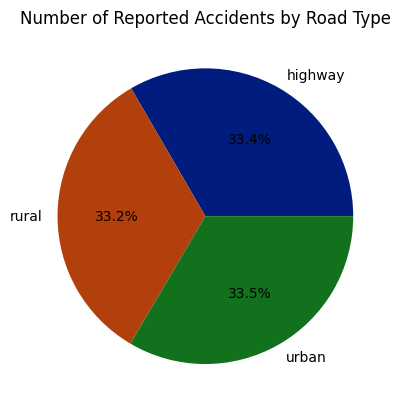

In [4]:
road_accident = df.groupby('road_type')['num_reported_accidents'].mean().reset_index()

colors = sb.color_palette('dark')
road_accident.plot.pie(
    y='num_reported_accidents',
    labels=road_accident['road_type'],
    autopct='%1.1f%%',
    legend = False,
    colors = colors,
    ylabel='',  # removes default y-axis label
    title='Number of Reported Accidents by Road Type',
    #figsize=(9, 11)
);

## 2. Were road signs present in most of the accident cases?

In [5]:
df.groupby('road_signs_present')['num_reported_accidents'].mean().reset_index()

,road_signs_present,num_reported_accidents
0,False,1.188114
1,True,1.187824


## 3. Does weather condition affect accident risk?

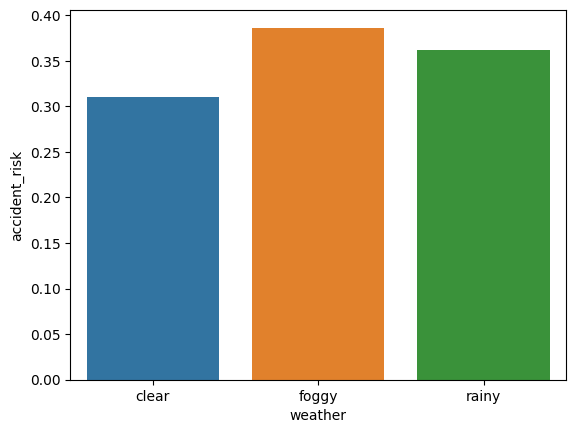

In [6]:
weather_accident = df.groupby('weather')['accident_risk'].mean().reset_index()

sb.barplot(weather_accident,x='weather',y='accident_risk');

# Feature Engineering

In [7]:
def feature_engineer(df):
    df_copy = df.copy()
    
    df_copy['road_signs_present'] = (df_copy['road_signs_present'] == True).astype(int)
    df_copy['public_road'] = (df_copy['public_road'] == True).astype(int)
    df_copy['holiday'] = (df_copy['holiday'] == True).astype(int)
    df_copy['school_season'] = (df_copy['school_season'] == True).astype(int)

    #create new features
    df_copy['road_complexity'] = df_copy['curvature'] * df_copy['num_lanes']#curvature × num_lanes
    df_copy['lane_density'] = df_copy['speed_limit'] / df_copy['num_lanes']
    
    def label(x):
        if x == 'morning':
            return 1
        if x == 'afternoon':
            return 2
        if x == 'evening':
            return 3

    df_copy['time_of_day'] = df_copy['time_of_day'].map(label)

    # Create encoder with unknown handling
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Fit and transform
    result = encoder.fit_transform(df_copy[['road_type','lighting','weather']])

    # Convert to DataFrame with readable column names
    encoded_df = pd.DataFrame(result, columns=encoder.get_feature_names_out(
    ['road_type','lighting','weather']), index=df_copy.index) 

    df_copy= pd.concat([df_copy,encoded_df], axis=1)

    df_copy = df_copy.drop(['road_type','lighting','weather'],axis=1)

    return df_copy

In [8]:
train = feature_engineer(df)

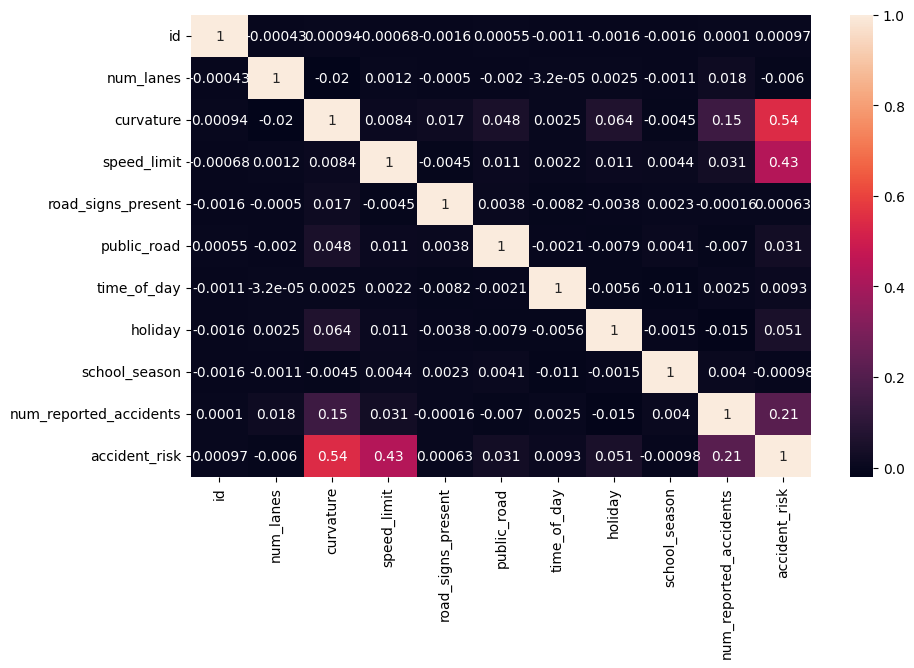

In [9]:
first_ = train.iloc[:,:11].columns.tolist()

plt.figure(figsize=(10,6))
sb.heatmap(train[first_].corr(numeric_only = True),annot=True);

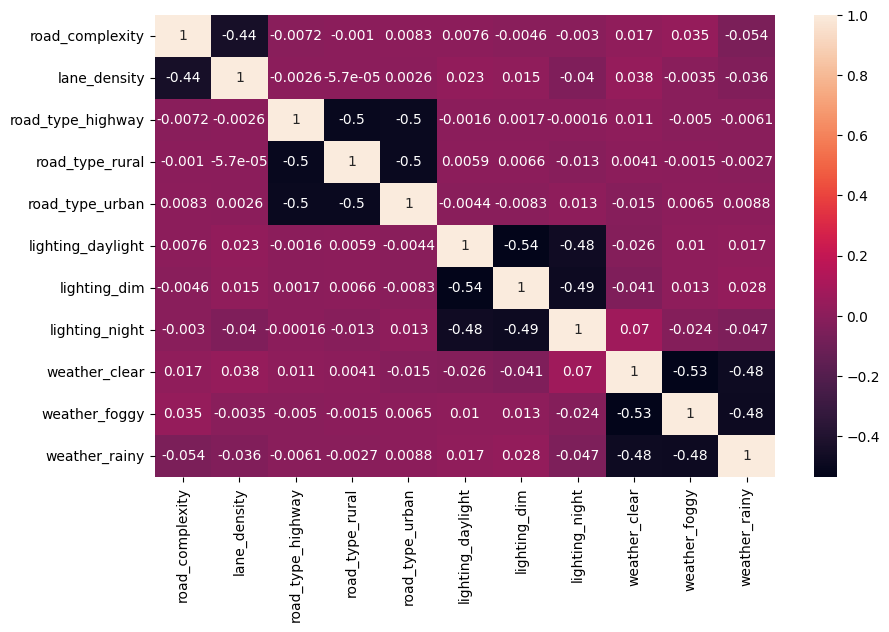

In [10]:
last_= train.iloc[:,11:].columns.tolist()

plt.figure(figsize=(10,6))
sb.heatmap(train[last_].corr(numeric_only = True),annot=True);

In [11]:
X = train.drop('accident_risk',axis=1)
y = train['accident_risk']

In [12]:
# performing preprocessing part

sc = StandardScaler()

X_scaled = sc.fit_transform(X)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size= 0.2, random_state=42)

In [14]:
#model

lg = LGBMRegressor(
       n_estimators = 100,
        n_leaves = 31,
        reg_alpha = 0.0,
        reg_lambda = 0.0,
        max_depth = -1,
        learning_rate = 0.1, 
)
lg.fit(X_train,y_train)

lg_model = lg.predict(X_val)

np.sqrt(mean_squared_error(y_val,lg_model))/y.mean()

[LightGBM] [Warning] Unknown parameter: n_leaves
[LightGBM] [Warning] Unknown parameter: n_leaves
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 745
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 21
[LightGBM] [Info] Start training from score 0.352605
[LightGBM] [Warning] Unknown parameter: n_leaves


0.1599169463631135

In [15]:
#lg.get_params()  0.1599169463631135

# Submission

In [16]:
test = feature_engineer(test_df)

In [17]:
predictions = lg.predict(test)

[LightGBM] [Warning] Unknown parameter: n_leaves


In [18]:
submission = test[['id']]

In [19]:
submission['accident_risk'] = predictions

/tmp/ipykernel_13/363289967.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['accident_risk'] = predictions


In [20]:
submission['accident_risk'] = submission['accident_risk'].apply(lambda x:(round(x,2)))

/tmp/ipykernel_13/3961751227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['accident_risk'] = submission['accident_risk'].apply(lambda x:(round(x,2)))


In [21]:
submission = submission.reset_index(drop=True)

In [22]:
submission.to_csv('submission.csv', index=False)